In [46]:
import pyomo.environ as pyo

from scipy.spatial.distance import pdist, squareform

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import time
from itertools import cycle

#from pyomo.contrib.appsi.solvers import Highs

import pandas as pd
from decimal import Decimal

In [47]:
# FILE = 'test1'
# ACCURATE = False
# FILE = 'shuffled_ordered_data/R211_shuffled_ordered'
FILE = 'shuffled_data/RC201_shuffled'
# FILE = 'test_data/test6'
# FILE = 'test_data/R211_test'
# FILE = 'experiment2_data/C201_test'
FILE_NAME = "C:/Users/caleb/Desktop/Study/FYP/Data/"+FILE+".csv"
data = pd.read_csv(FILE_NAME)
data.columns = data.columns.astype(str)

In [48]:
PLANNING_TIME = 0
CUSTOMERS_LIST = []
data = data.loc[(data['DUE DATE'] >= PLANNING_TIME) | (data['CUST NO.'].isin(CUSTOMERS_LIST))]
data.shape

(101, 12)

In [49]:
N = 100
CAPACITY = 50
N_VEHICLES = 3
R = 3 #number of trips. set to a fiarly large number
DEMAND_TYPES = 5
VEHICLE_COMPARMENTS = 5

vehicle_capacities = np.array([[CAPACITY]*DEMAND_TYPES]*N_VEHICLES)
df = data[:N+1]
cust_no = np.array(df.loc[:,'CUST NO.'])
demands = np.array(df.loc[:,'DEMAND'])
service_time = demands#np.array(df.loc[:,'SERVICE TIME'])#demands #np.zeros(len(demands)) #demands 
demands_zeros = np.zeros((len(demands), DEMAND_TYPES-1))
demands = np.hstack((demands.reshape(N+1,1),demands_zeros))
coordinates = np.array(df.loc[:,['XCOORD','YCOORD']])
start_time_windows = np.array(df.loc[:,'READY TIME'])
end_time_windows = np.array(df.loc[:,'DUE DATE']) #+ service_time

demands_index = [i for i in range(1,N+1)]

START_TIME = start_time_windows[0]
# START_TIME = 100
END_TIME = end_time_windows[0] #+ service_time[1]

print(START_TIME)
print(END_TIME)

0
960


In [50]:
coordinates

array([[40, 50],
       [25, 85],
       [22, 75],
       [22, 85],
       [20, 80],
       [20, 85],
       [18, 75],
       [15, 75],
       [15, 80],
       [10, 35],
       [10, 40],
       [ 8, 40],
       [ 8, 45],
       [ 5, 35],
       [ 5, 45],
       [ 2, 40],
       [ 0, 40],
       [ 0, 45],
       [44,  5],
       [42, 10],
       [42, 15],
       [40,  5],
       [40, 15],
       [38,  5],
       [38, 15],
       [35,  5],
       [95, 30],
       [95, 35],
       [92, 30],
       [90, 35],
       [88, 30],
       [88, 35],
       [87, 30],
       [85, 25],
       [85, 35],
       [67, 85],
       [65, 85],
       [65, 82],
       [62, 80],
       [60, 80],
       [60, 85],
       [58, 75],
       [55, 80],
       [55, 85],
       [55, 82],
       [20, 82],
       [18, 80],
       [ 2, 45],
       [42,  5],
       [42, 12],
       [72, 35],
       [55, 20],
       [25, 30],
       [20, 50],
       [55, 60],
       [30, 60],
       [50, 35],
       [30, 25],
       [15, 10

In [51]:
end_time_windows

array([960, 793, 272, 591, 764, 193, 508, 420, 487, 491, 639, 315, 343,
       773, 155, 294, 375, 823, 455, 374, 657, 335, 495, 321, 801, 904,
       649, 266, 269, 314, 366, 285, 741, 200, 607, 777, 163, 677, 398,
       184, 449, 496, 153, 694, 337, 157, 609, 225, 852, 560, 627, 446,
       295, 495, 721, 719, 677, 517, 902, 162, 814, 378, 287, 159, 311,
       131, 686, 388, 732, 277, 930, 361, 180, 406, 765, 352, 388, 884,
       485, 472, 942, 475, 272, 225, 515, 464, 469, 479, 380, 833, 479,
       839, 134, 928, 512, 220, 682, 667, 292, 428, 930], dtype=int64)

In [52]:
def crazyshuffle(arr,seed):
    rng = np.random.default_rng(seed=seed)
    x, y = arr.shape
    rows = np.indices((x,y))[0]
    cols = [rng.permutation(y) for _ in range(x)]
    return arr[rows, cols]

In [53]:
demands_empty = np.zeros(demands.shape)
count = 0
for i , demand in enumerate(demands):
    for j , d in enumerate(demand):
        if d != 0:
            demands_empty[i,count] = demands[i,j]
            if count < DEMAND_TYPES-1:
                count += 1
            else:
                count = 0
demands_empty

array([[ 0.,  0.,  0.,  0.,  0.],
       [20.,  0.,  0.,  0.,  0.],
       [ 0., 30.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0., 40.,  0.],
       [ 0.,  0.,  0.,  0., 20.],
       [20.,  0.,  0.,  0.,  0.],
       [ 0., 20.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0., 20.,  0.],
       [ 0.,  0.,  0.,  0., 30.],
       [40.,  0.,  0.,  0.,  0.],
       [ 0., 20.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0., 20.],
       [20.,  0.,  0.,  0.,  0.],
       [ 0., 20.,  0.,  0.,  0.],
       [ 0.,  0., 20.,  0.,  0.],
       [ 0.,  0.,  0., 40.,  0.],
       [ 0.,  0.,  0.,  0., 10.],
       [10.,  0.,  0.,  0.,  0.],
       [ 0., 40.,  0.,  0.,  0.],
       [ 0.,  0., 30.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0., 20.],
       [30.,  0.,  0.,  0.,  0.],
       [ 0., 20.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0.,  

In [54]:
SEED = 69
#service_time = demands #np.array(df.loc[:,'SERVICE TIME'])
demands_shuffled = crazyshuffle(demands,SEED)#demands#demands_empty#crazyshuffle(demands,SEED)
demands_shuffled

array([[ 0.,  0.,  0.,  0.,  0.],
       [20.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 30.],
       [ 0.,  0.,  0.,  0., 10.],
       [ 0.,  0.,  0., 40.,  0.],
       [20.,  0.,  0.,  0.,  0.],
       [ 0., 20.,  0.,  0.,  0.],
       [20.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 10.],
       [ 0.,  0., 20.,  0.,  0.],
       [ 0.,  0.,  0., 30.,  0.],
       [ 0., 40.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 20.,  0.],
       [10.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.],
       [ 0., 20.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 20.],
       [20.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 20.,  0.,  0.],
       [40.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.],
       [ 0., 10.,  0.,  0.,  0.],
       [ 0.,  0., 40.,  0.,  0.],
       [ 0.,  0.,  0., 30.,  0.],
       [ 0., 10.,  0.,  0.,  0.],
       [20.,  0.,  0.,  0.,  0.],
       [30.,  0.,  0.,  0.,  0.],
       [ 0., 20.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  0.],
       [ 0., 1

In [55]:
demands_shuffled = np.array(df.iloc[:,4:9])
demands_shuffled

array([[ 0,  0,  0,  0,  0],
       [20,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30],
       [ 0,  0,  0,  0, 10],
       [ 0,  0,  0, 40,  0],
       [20,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0],
       [20,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 10],
       [ 0,  0, 20,  0,  0],
       [ 0,  0,  0, 30,  0],
       [ 0, 40,  0,  0,  0],
       [ 0,  0,  0, 20,  0],
       [10,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0],
       [ 0, 20,  0,  0,  0],
       [ 0,  0,  0,  0, 20],
       [20,  0,  0,  0,  0],
       [ 0,  0, 20,  0,  0],
       [40,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0, 40,  0,  0],
       [ 0,  0,  0, 30,  0],
       [ 0, 10,  0,  0,  0],
       [20,  0,  0,  0,  0],
       [30,  0,  0,  0,  0],
       [ 0, 20,  0,  0,  0],
       [ 0,  0, 10,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0,  0,  0, 10],
       [ 0,  0,  0, 20,  0],
       [ 0, 10,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0

In [56]:
TOTAL_GOODS = demands_shuffled.sum()
TOTAL_GOODS

1724

In [57]:
print('Max possible score:', np.abs(demands_shuffled).sum())
#print('Max goods:', np.abs(demands).sum()/2)
print ('Veh max Capacity:', vehicle_capacities.sum())

Max possible score: 1724
Veh max Capacity: 750


In [58]:
distances = squareform(pdist(coordinates, metric="euclidean"))
def trunc(values, decs=1):
    return np.trunc(values*10**decs)/(10**decs)
distances = trunc(distances)
# distances = np.round(distances, decimals=2)

#travel_time = distances/5
travel_time = distances
# travel_time

In [59]:

# distances_decimal = np.array([[round(Decimal(y),1) for y in x]for x in distances])
# distances_decimal = trunc(distances_decimal)
# distances_decimal[0,5]

In [60]:
# travel_time[0,29]

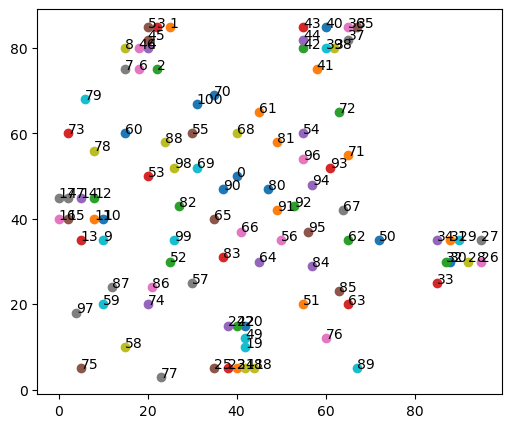

In [61]:
# Choosing colors
cmap = mpl.colormaps["Dark2"]
colors = cycle(cmap.colors)

# Now the figure
fig, ax = plt.subplots(figsize=[6, 5], dpi=100)

for i, coord in enumerate(coordinates):
    x = coord[0]
    y= coord[1]
    ax.scatter(x,y)
    ax.annotate(i, (x,y))

In [62]:
model = pyo.ConcreteModel()

## Sets

In [63]:
model.D = pyo.Set(initialize=demands_index) #set of vessels
model.N = pyo.Set(initialize=range(len(demands))) # set of vessels+depot
model.N1 = pyo.Set(initialize=range(len(demands)+1)) # set of vessels+depot+end
model.A = pyo.Set(initialize=[(i, j) for i in model.N for j in model.N if i != j]) #set of arcs
# model.A = pyo.Set(initialize=[(i, j) for (i,j) in arcs_index]) #set of arcs
#model.V = pyo.Set(initialize=[i for i in model.N]) #set of nodes
model.K = pyo.Set(initialize=range(N_VEHICLES)) #set of vehicles
model.R  = pyo.Set(initialize=range(R)) # set of trips
model.F = pyo.Set(initialize = range(DEMAND_TYPES)) #set of demand types

## Parameters

In [64]:
zeta = 0.1 # travel cost per distance factor
price = [1]*DEMAND_TYPES

In [65]:
model.q = pyo.Param(model.K, model.F, initialize={(i,f): vehicle_capacities[i,f] for i in model.K for f in model.F}) #capacity of vehicles
model.c = pyo.Param(model.A, initialize={(i, j): zeta*distances[i, j] for (i, j) in model.A}) #cost of travel per arc
model.n = pyo.Param(model.N, model.F, initialize={(i,f): demands_shuffled[i,f] for i in model.N for f in model.F}) #loading of all nodes
model.r = pyo.Param(model.N, model.F, initialize={(i,f): price[f]*demands_shuffled[i,f] for i in model.N for f in model.F}) #revenue of all nodes
model.s = pyo.Param(model.N, initialize=service_time) #service time per node
model.t = pyo.Param(model.N, model.N, initialize={(i, j): travel_time[i, j] for i in model.N for j in model.N}) #travel time per arc)
# model.t = pyo.Param(model.N, model.N, initialize={(i, j): travel_time[i, j] for i in model.N for j in model.N}) #travel time per arc)
model.a = pyo.Param(model.N, initialize=start_time_windows) #start time windows per node
model.b = pyo.Param(model.N, initialize=end_time_windows) #end time windows per node

## Variables

In [66]:
new_start_time_windows = np.append(start_time_windows, START_TIME)
new_start_time_windows = [[new_start_time_windows]*R]*N_VEHICLES

new_end_time_windows = np.append(end_time_windows, END_TIME)
new_end_time_windows = [[new_end_time_windows]*R]*N_VEHICLES

In [67]:
def time_windows(model, i,k,r):
    return (new_start_time_windows[k][r][i], new_end_time_windows[k][r][i])

## Variables

In [68]:
model.X = pyo.Var(model.A, model.K, model.R, within=pyo.Binary) # decision to move along arc ij by vehicle K on trip R
model.Y = pyo.Var(model.N, model.K, model.R, within=pyo.Binary) # decision of if node N is visited by vehicle K on trip R

In [69]:

#model.Q = pyo.Var(model.N, model.K, model.R, within=pyo.NonNegativeReals) #sum of all load before serving node N on vehicle K on trip R
model.T = pyo.Var(model.N1, model.K, model.R, within=pyo.NonNegativeReals, bounds= time_windows) # visit time at node N by vehicle K on trip R
model.S = pyo.Var(model.K, model.R, within=pyo.NonNegativeReals, bounds= (0,CAPACITY*DEMAND_TYPES)) #serivce time at the depot for the start of each trip

# model.Z = pyo.Var(model.K, model.R, model.F, within=pyo.Binary) #decision if fuel type f is carried by vehicle K on trip R

model.L = pyo.Var([0,N+1], model.K, model.R, model.F, within=pyo.NonNegativeReals, bounds= (0,CAPACITY)) # fuel load on vehicle K on trip R for fuel type F
# model.L_initial = pyo.Var(model.K, model.F, within=pyo.NonNegativeReals, bounds= (0,CAPACITY))
model.U = pyo.Var(model.N, model.K, model.R, model.F, within=pyo.NonNegativeReals, bounds= (0,CAPACITY))

## Constraints

In [70]:
len(demands)

101

In [71]:
# B = END_TIME*5 #arbitary large number beyond endtime to solve subtour elimination
# M = 1e6 # arbitary large constant
M = np.zeros((N+1,N+1))
# beta = 1 
beta = 0.2 # rate of fuel transfer at the depot
for i in model.N:
    for j in model.N:
         M[i,j] = model.b[i] + model.s[i] + model.t[i,j] - model.a[j]
      #    M[i,j] =  model.b[i] + model.s[i] + travel_time[i,j] 
for j in model.N:
      M[0,j] = model.b[0] + CAPACITY*DEMAND_TYPES*beta + model.t[0,j] - model.a[j]
      # M[0,j] =  model.b[0] +CAPACITY*DEMAND_TYPES*0.2 + travel_time[0,j]
print(np.max(M))
# M = np.max(M)

1010.7


In [72]:
# M = 1e3
# print(M)

In [73]:
def visit_once_rule(model,i): #2/13
    return sum(model.Y[i,k,r] for k in model.K for r in model.R) <= 1
model.visit_once_rule = pyo.Constraint(model.D, rule=visit_once_rule)

def arcs_out_rule(model, i, k,r): #3/14 modifyied Arcs out rule
    return sum(model.X[i, j, k,r] for j in model.N if i != j) == model.Y[i,k,r]
model.arcs_out_rule = pyo.Constraint(model.N, model.K, model.R, rule=arcs_out_rule)

def arcs_in_rule(model, i, k,r): #3/14 modifyied Arcs in rule
    return sum(model.X[j, i, k,r] for j in model.N if i != j) == model.Y[i,k,r]
model.arcs_in_rule = pyo.Constraint(model.N, model.K, model.R, rule=arcs_in_rule)

def feasbile_time_along_arc(model,i,j, k,r): #71
    if i == j:
        return pyo.Constraint.Skip
    else:
        # return model.T[i,k,r] + model.s[i] + model.t[i,j] <= model.T[j,k,r] + M*(1-model.X[i,j,k,r])
        return model.T[i,k,r] + model.s[i] + model.t[i,j] <= model.T[j,k,r] + M[i,j]*(1-model.X[i,j,k,r])
model.feasbile_time_along_arc = pyo.Constraint(model.D, model.D, model.K, model.R, rule=feasbile_time_along_arc)

def feasbile_start_time (model,j,k,r): #72 
    # return model.T[0,k,r] + model.S[k,r] + model.t[0,j] <= model.T[j,k,r] + M*(1-model.X[0,j,k,r])
    return model.T[0,k,r] + model.S[k,r] + model.t[0,j] <= model.T[j,k,r] + M[0,j]*(1-model.X[0,j,k,r])
model.feasbile_start_time = pyo.Constraint(model.D, model.K, model.R, rule=feasbile_start_time)

def feasbile_end_time (model,i,k,r): #66
    # return model.T[i,k,r] + model.s[i] + model.t[i,0] <= model.T[N+1,k,r] + M*(1-model.X[i,0,k,r])
    return model.T[i,k,r] + model.s[i] + model.t[i,0] <= model.T[N+1,k,r] + M[i,0]*(1-model.X[i,0,k,r])
model.feasbile_end_time = pyo.Constraint(model.D, model.K, model.R, rule=feasbile_end_time)

'''
def trip_start_after_end (model, k,r): #modified (may not be needed)
    if r == model.R.first():
        return pyo.Constraint.Skip
    else:
        return model.T[N+1,k,r-1] <= model.T[0,k,r]
    
model.trip_start_after_end = pyo.Constraint(model.K, model.R, rule=trip_start_after_end)   
'''
def trip_end_before_start (model, k,r): #67
    if r == model.R.last():
        return pyo.Constraint.Skip
    else:
        return model.T[N+1,k,r] <= model.T[0,k,r+1]
model.trip_end_before_start = pyo.Constraint(model.K, model.R, rule=trip_end_before_start)    

def trip_end_after_start (model, k,r): #modified (necessary)
    return model.T[0,k,r] + model.S[k,r] <= model.T[N+1,k,r]
model.trip_end_after_start = pyo.Constraint(model.K, model.R, rule=trip_end_after_start)    
'''
def trip_start_after_time_window_start (model, i,k,r): #68
    # return model.a[i] *model.Y[i,k,r] <= model.T[i,k,r]
    return model.a[i] <= model.T[i,k,r]
model.trip_start_after_time_window_start = pyo.Constraint(model.D, model.K, model.R, rule=trip_start_after_time_window_start)

def trip_end_before_time_window_end (model, i,k,r): #68 
    return model.T[i,k,r] <= (model.b[i]) #*model.Y[i,k,r]
    # return model.T[i,k,r] <= (model.b[i]- model.s[i])*model.Y[i,k,r]  #modified to include service time
model.trip_end_before_time_window_end = pyo.Constraint(model.D, model.K, model.R, rule=trip_end_before_time_window_end)

def trip_end_before_end_time(model,k,r): # 69
    return model.T[N+1,k,r] <= END_TIME
model.trip_end_before_end_time = pyo.Constraint(model.K, model.R, rule=trip_end_before_end_time)'''


'\ndef trip_start_after_time_window_start (model, i,k,r): #68\n    # return model.a[i] *model.Y[i,k,r] <= model.T[i,k,r]\n    return model.a[i] <= model.T[i,k,r]\nmodel.trip_start_after_time_window_start = pyo.Constraint(model.D, model.K, model.R, rule=trip_start_after_time_window_start)\n\ndef trip_end_before_time_window_end (model, i,k,r): #68 \n    return model.T[i,k,r] <= (model.b[i]) #*model.Y[i,k,r]\n    # return model.T[i,k,r] <= (model.b[i]- model.s[i])*model.Y[i,k,r]  #modified to include service time\nmodel.trip_end_before_time_window_end = pyo.Constraint(model.D, model.K, model.R, rule=trip_end_before_time_window_end)\n\ndef trip_end_before_end_time(model,k,r): # 69\n    return model.T[N+1,k,r] <= END_TIME\nmodel.trip_end_before_end_time = pyo.Constraint(model.K, model.R, rule=trip_end_before_end_time)'

## Fuel type constraints

In [74]:
'''
#i think if the total goods number is too big, it can cause issues
def lower_fuel_type_in_veh (model,k,r,f): #added to count types of fuel carried
    return sum(model.n[i,f] * model.Y[i,k,r] for i in model.D) / TOTAL_GOODS <= model.Z[k,r,f] 
model.lower_fuel_type_in_veh = pyo.Constraint(model.K,model.R, model.F, rule=lower_fuel_type_in_veh)

def upper_fuel_type_in_veh (model,k,r,f): #added to count types of fuel carried
    return model.Z[k,r,f]  <= sum(model.n[i,f] * model.Y[i,k,r] for i in model.D)
model.upper_fuel_type_in_veh = pyo.Constraint(model.K,model.R, model.F, rule=upper_fuel_type_in_veh)

def fuel_types_in_veh_within_limits(model,k,r): #added so that fuel types carried is lesser than no of comparments
    return sum(model.Z[k,r,f] for f in model.F) <= VEHICLE_COMPARMENTS
model.fuel_types_in_veh_within_limits = pyo.Constraint(model.K,model.R,rule=fuel_types_in_veh_within_limits)
'''

'\n#i think if the total goods number is too big, it can cause issues\ndef lower_fuel_type_in_veh (model,k,r,f): #added to count types of fuel carried\n    return sum(model.n[i,f] * model.Y[i,k,r] for i in model.D) / TOTAL_GOODS <= model.Z[k,r,f] \nmodel.lower_fuel_type_in_veh = pyo.Constraint(model.K,model.R, model.F, rule=lower_fuel_type_in_veh)\n\ndef upper_fuel_type_in_veh (model,k,r,f): #added to count types of fuel carried\n    return model.Z[k,r,f]  <= sum(model.n[i,f] * model.Y[i,k,r] for i in model.D)\nmodel.upper_fuel_type_in_veh = pyo.Constraint(model.K,model.R, model.F, rule=upper_fuel_type_in_veh)\n\ndef fuel_types_in_veh_within_limits(model,k,r): #added so that fuel types carried is lesser than no of comparments\n    return sum(model.Z[k,r,f] for f in model.F) <= VEHICLE_COMPARMENTS\nmodel.fuel_types_in_veh_within_limits = pyo.Constraint(model.K,model.R,rule=fuel_types_in_veh_within_limits)\n'

## Service time at depot

In [75]:
full_capacity = [CAPACITY]*VEHICLE_COMPARMENTS

def service_time_at_depot (model,k,r): #73 modified
    if r == model.R.first():
        return model.S[k,r] == 0 #beta * (sum(full_capacity)- sum(model.L_initial[k,f] for f in model.F))
    else:
        return model.S[k,r] == beta* (sum(full_capacity) - sum(model.L[N+1,k,r-1,f] for f in model.F))
model.service_time_at_depot = pyo.Constraint(model.K, model.R, rule=service_time_at_depot)
'''

def service_time_at_depot (model,k,r): #73 modified
    if r == model.R.first():
        return model.S[k,r] == 0 #beta * (sum(full_capacity)- sum(model.L_initial[k,f] for f in model.F))
    else:
        return model.S[k,r] == beta* (sum(model.L[0,k,r,f] for f in model.F) - sum(model.L[N+1,k,r-1,f] for f in model.F))
model.service_time_at_depot = pyo.Constraint(model.K, model.R, rule=service_time_at_depot)
'''
'''
def service_time_at_depot (model,k,r): #73 modified
    return model.S[k,r] == beta* sum(model.s[i] * model.Y[i,k,r] for i in model.D)
model.service_time_at_depot = pyo.Constraint(model.K, model.R, rule=service_time_at_depot)
'''


'\ndef service_time_at_depot (model,k,r): #73 modified\n    return model.S[k,r] == beta* sum(model.s[i] * model.Y[i,k,r] for i in model.D)\nmodel.service_time_at_depot = pyo.Constraint(model.K, model.R, rule=service_time_at_depot)\n'

## Vehicle Loading

In [76]:
'''
def loading_within_veh_capcity (model,k,r,f): #4 modifiied for multi-commodity
    return sum(model.n[i,f] * model.Y[i,k,r] for i in model.D)<= model.q[k,f]
model.loading_within_veh_capcity = pyo.Constraint(model.K,model.R, model.F,rule=loading_within_veh_capcity)
'''

'\ndef loading_within_veh_capcity (model,k,r,f): #4 modifiied for multi-commodity\n    return sum(model.n[i,f] * model.Y[i,k,r] for i in model.D)<= model.q[k,f]\nmodel.loading_within_veh_capcity = pyo.Constraint(model.K,model.R, model.F,rule=loading_within_veh_capcity)\n'

In [77]:
'''
def fuel_del_at_nodes(model,i,f):
    return sum(model.U[i,k,r,f] for k in model.K for r in model.R) == model.n[i,f]
model.fuel_del_at_nodes = pyo.Constraint(model.N, model.F,rule=fuel_del_at_nodes)
'''
def fuel_del_to_visit(model,i,k,r,f): #if cust i is visited, U>0 else set  U = 0
    return model.U[i,k,r,f] == model.Y[i,k,r] * model.n[i,f]

    #  return model.U[i,k,r,f] <= model.Y[i,k,r] * CAPACITY
model.fuel_del_to_visit = pyo.Constraint(model.N, model.K, model.R, model.F,rule=fuel_del_to_visit)

def fuel_load_in_veh_at_start(model,k,r,f): #10
    if r == model.R.first():
        return pyo.Constraint.Skip #loading for first trip would be handled later
    else:
        # return pyo.Constraint.Skip
        return model.L[0,k,r,f] == full_capacity[f]
model.fuel_load_in_veh_at_start = pyo.Constraint(model.K,model.R, model.F,rule=fuel_load_in_veh_at_start)

'''
def fuel_load_in_veh_at_nodes(model,i,j,k,r,f):
        if i == j:
            return pyo.Constraint.Skip
        else:
            return model.L[j,k,r,f] <= model.L[i,k,r,f] - model.U[i,k,r,f]
model.fuel_load_in_veh_at_nodes = pyo.Constraint(model.D,model.D, model.K,model.R, model.F,rule=fuel_load_in_veh_at_nodes)
'''
def load_in_veh_at_end(model,k,r,f): #fuel load at end same as or exceeds the load for the trip
    return model.L[N+1,k,r,f] == model.L[0,k,r,f] - sum(model.U[i,k,r,f] for i in model.N) 
model.load_in_veh_at_end = pyo.Constraint(model.K,model.R, model.F,rule=load_in_veh_at_end)

'''
def fuel_load_if_trip_not_used (model,j,k,r,f):
    return model.L[N+1,k,r,f] <= model.L[0,k,r,f] + M*sum(model.Y[i,k,r] for i in model.D)

model.fuel_load_if_trip_not_used = pyo.Constraint(model.D,model.K,model.R, model.F,rule=fuel_load_if_trip_not_used)'''

'\ndef fuel_load_if_trip_not_used (model,j,k,r,f):\n    return model.L[N+1,k,r,f] <= model.L[0,k,r,f] + M*sum(model.Y[i,k,r] for i in model.D)\n\nmodel.fuel_load_if_trip_not_used = pyo.Constraint(model.D,model.K,model.R, model.F,rule=fuel_load_if_trip_not_used)'

def fuel_load_in_veh_at_start(model,k,r,f): #10
    if r == model.R.first():
        return model.L[0,k,r,f] == model.L_initial[k,f]
    else:
        return model.L[0,k,r,f] == full_capacity[f]
model.fuel_load_in_veh_at_start = pyo.Constraint(model.K,model.R, model.F,rule=fuel_load_in_veh_at_start)

'''
def upper_fuel_load_in_veh_at_start_to_nodes(model,j,k,r,f): #fuel load at depot same as or exceeds the load for the trip
    return model.L[j,k,r,f] <= model.L[0,k,r,f] - model.n[0,f] + M*(1-model.X[0,j,k,r])
model.upper_fuel_load_in_veh_at_start_to_nodes = pyo.Constraint(model.D, model.K,model.R, model.F,rule=upper_fuel_load_in_veh_at_start_to_nodes)

def lower_fuel_load_in_veh_at_start_to_nodes(model,j,k,r,f): #fuel load at depot same as or exceeds the load for the trip
    return model.L[j,k,r,f] + M*(1-model.X[0,j,k,r]) >= model.L[0,k,r,f] - model.n[0,f] 
model.lower_fuel_load_in_veh_at_start_to_nodes = pyo.Constraint(model.D, model.K,model.R, model.F,rule=lower_fuel_load_in_veh_at_start_to_nodes)
'''
if ACCURATE:
    def upper_fuel_load_in_veh_at_nodes(model,i,j,k,r,f):
        if i == j:
            return pyo.Constraint.Skip
        else:
            return model.L[j,k,r,f] <= model.L[i,k,r,f] - model.n[i,f] + M*(1-model.X[i,j,k,r])
    model.upper_fuel_load_in_veh_at_nodes = pyo.Constraint(model.N, model.D, model.K,model.R, model.F,rule=upper_fuel_load_in_veh_at_nodes)

    def lower_fuel_load_in_veh_at_nodes(model,i,j,k,r,f):
        if i == j:
            return pyo.Constraint.Skip
        else:
            # return model.L[j,k,r,f] <= model.L[i,k,r,f] - model.n[i,f] + M*(1-model.X[i,j,k,r])
            return model.L[j,k,r,f] + M*(1-model.X[i,j,k,r]) >= model.L[i,k,r,f] - model.n[i,f] 
    model.lower_fuel_load_in_veh_at_nodes = pyo.Constraint(model.N, model.D, model.K,model.R, model.F,rule=lower_fuel_load_in_veh_at_nodes)
    def upper_fuel_load_in_veh_at_end(model,i,k,r,f): #fuel load at end same as or exceeds the load for the trip
        return model.L[N+1,k,r,f] <= model.L[i,k,r,f] - model.n[i,f] + M*(1-model.X[i,0,k,r])

    model.upper_fuel_load_in_veh_at_end = pyo.Constraint(model.D,model.K,model.R, model.F,rule=upper_fuel_load_in_veh_at_end)

    def lower_fuel_load_in_veh_at_end(model,i,k,r,f): #fuel load at end same as or exceeds the load for the trip
        return model.L[N+1,k,r,f] + M*(1-model.X[i,0,k,r]) >= model.L[i,k,r,f] - model.n[i,f] 

    model.lower_fuel_load_in_veh_at_end = pyo.Constraint(model.D,model.K,model.R, model.F,rule=lower_fuel_load_in_veh_at_end)


    def upper_fuel_load_if_trip_not_used (model,j,k,r,f):
        return model.L[N+1,k,r,f] <= model.L[0,k,r,f] + M*sum(model.Y[i,k,r] for i in model.D)

    model.upper_fuel_load_if_trip_not_used = pyo.Constraint(model.D,model.K,model.R, model.F,rule=upper_fuel_load_if_trip_not_used)

    def lower_fuel_load_if_trip_not_used (model,j,k,r,f):
        return model.L[N+1,k,r,f] + M*sum(model.Y[i,k,r] for i in model.D) >= model.L[0,k,r,f] 

    model.lower_fuel_load_if_trip_not_used = pyo.Constraint(model.D,model.K,model.R, model.F,rule=lower_fuel_load_if_trip_not_used)

else:
    def load_in_veh_at_nodes(model,i,j,k,r,f):
        if i == j:
            return pyo.Constraint.Skip
        else:
            return model.L[j,k,r,f] <= model.L[i,k,r,f] - model.n[i,f] + M*(1-model.X[i,j,k,r])
    model.load_in_veh_at_nodes = pyo.Constraint(model.N, model.D, model.K,model.R, model.F,rule=load_in_veh_at_nodes)
    
    def load_in_veh_at_end(model,i,k,r,f): #fuel load at end same as or exceeds the load for the trip
        return model.L[N+1,k,r,f] <= model.L[i,k,r,f] - model.n[i,f] + M*(1-model.X[i,0,k,r])
    model.load_in_veh_at_end = pyo.Constraint(model.D,model.K,model.R, model.F,rule=load_in_veh_at_end)
    
    def fuel_load_if_trip_not_used (model,j,k,r,f):
        return model.L[N+1,k,r,f] <= model.L[0,k,r,f] + M*sum(model.Y[i,k,r] for i in model.D)

    model.fuel_load_if_trip_not_used = pyo.Constraint(model.D,model.K,model.R, model.F,rule=fuel_load_if_trip_not_used)



## Objective

In [78]:
'''
#obj to minise travel cost
model.obj = pyo.Objective(
    expr=sum(
        model.X[i, j, k,r] * model.t[i,j]
        for (i, j) in model.A
        for k in model.K
        for r in model.R
        ), 
    sense=pyo.minimize,
)
'''
'''
#obj without travel costs
model.obj = pyo.Objective(
    expr=sum(
        model.Y[i, k,r] * np.abs(model.n[i,f])
        for i in model.D
        for k in model.K
        for r in model.R
        for f in model.F
        ), 
    sense=pyo.maximize,
)
'''

#obj with travel costs
model.obj = pyo.Objective(
    expr=sum(
        model.Y[i, k,r] * np.abs(model.r[i,f])
        for i in model.D
        for k in model.K
        for r in model.R
        for f in model.F
    ) - sum(model.X[i, j, k,r] * model.c[i,j]
        for (i, j) in model.A
        for k in model.K
        for r in model.R),
    sense=pyo.maximize,
)


## Inital Conditions

In [79]:
def route_pair(route):
    route_pair = []
    for i in range(len(route)-1):
        from_node = route[i]
        to_node = route[i+1]
        if from_node == to_node:
            raise Exception('i == j')
        else:
            route_pair.append((from_node,to_node))
    return route_pair

In [80]:
# np.where(cust_no == i for i in rouite[1,3])

In [81]:
full_capacity = [CAPACITY]*VEHICLE_COMPARMENTS
empty_capacity = [0]*VEHICLE_COMPARMENTS

route1_cust_no = [1]
route2_cust_no = [1]
route3_cust_no = [1]

depot_index = np.where(cust_no == 1)[0][0]
if len(route1_cust_no) != 0:
    route1_index = np.where(cust_no == route1_cust_no)[0][0]
else:
    route1_index = None
if len(route2_cust_no) != 0:
    route2_index = np.where(cust_no == route2_cust_no)[0][0]
else:
    route2_index = None
if len(route3_cust_no) != 0:
    route3_index = np.where(cust_no == route3_cust_no)[0][0]
else:
    route3_index = None

#time start at depot
time_start_1 = 0#50 - travel_time[depot_index,route1_index]
time_start_2 = 0#50 - travel_time[depot_index,route2_index]
time_start_3 = 0#50 - travel_time[depot_index,route3_index]

#loading of vehicle before top up
loading1 = full_capacity
loading2 = full_capacity
loading3 = full_capacity
#check that given load does not exceed vehicle capacity
for i, cap in enumerate(full_capacity):
    if (loading1[i] > cap) or (loading2[i] > cap) or (loading3[i] > cap) :
        raise Exception('Capacity over limit')
    

routes_initial = [route1_cust_no, route2_cust_no, route3_cust_no]
time_start_initial = [time_start_1,time_start_2,time_start_3]
loading_initial = [loading1,loading2,loading3]
'''
routes_initial = [route1_cust_no]#, route2_cust_no, route3_cust_no]
time_start_initial = [time_start_1]#,time_start_2,time_start_3]
loading_initial = [loading1]#,loading2,loading3]'''

'\nroutes_initial = [route1_cust_no]#, route2_cust_no, route3_cust_no]\ntime_start_initial = [time_start_1]#,time_start_2,time_start_3]\nloading_initial = [loading1]#,loading2,loading3]'

In [82]:
def trip_split(route):
    trip =[]
    temp = [0]
    for i in range(1, len(route)):
        temp.append(route[i])
        if route[i] == 0:
            trip.append(temp)
            temp = [0]
    return trip

In [83]:
print ("Time start 1:", time_start_1)
print ("Time start 2:", time_start_2)
print ("Time start 3:", time_start_3)

Time start 1: 0
Time start 2: 0
Time start 3: 0


In [84]:
# model.L_initial.pprint()

In [85]:
def inital_loading(model,k,f):
    return model.L[0,k,0,f] == loading_initial[k][f]

model.inital_loading = pyo.Constraint(model.K,model.F,rule=inital_loading)
'''
def inital_loading_1(model,f):
    # loading = loading1
    return model.L_initial[0,f] == loading1[f]

model.inital_loading_1 = pyo.Constraint(model.F,rule=inital_loading_1)

def inital_loading_2(model,f):
    # loading = loading2
    return model.L_initial[1,f] == loading2[f]

model.inital_loading_2 = pyo.Constraint(model.F,rule=inital_loading_2)

def inital_loading_3(model,f):
    # loading = loading3
    return model.L_initial[2,f] == loading3[f]

model.inital_loading_3 = pyo.Constraint(model.F,rule=inital_loading_3)
'''
if route1_index != 0:
    def inital_route_1(model):
        return model.X[0,route1_index,0,0] == 1
    model.inital_route_1 = pyo.Constraint(rule=inital_route_1)
if route2_index != 0:
    def inital_route_2(model):
        return model.X[0,route2_index,1,0] == 1
    model.inital_route_2 = pyo.Constraint(rule=inital_route_2)
if route3_index != 0:
    def inital_route_3(model):
        return model.X[0,route3_index,2,0] == 1
    model.inital_route_3 = pyo.Constraint(rule=inital_route_3)
'''
route1 = [np.where(cust_no == i)[0][0] for i in route1_cust_no]
route2 = [np.where(cust_no == i)[0][0] for i in route2_cust_no]
route3 = [np.where(cust_no == i)[0][0] for i in route3_cust_no]

route1 = trip_split(route1)
route2 = trip_split(route2)
route3 = trip_split(route3)

route_pair1 = [route_pair(route)for route in route1]
route_pair2 = [route_pair(route)for route in route2]
route_pair3 = [route_pair(route)for route in route3]
if len(route_pair1) > 0:
    def inital_route_1_0(model,i,j,r):
        return model.X[i,j,0,r] == 1
    model.inital_route_1_0 = pyo.Constraint(route_pair1[0],[0],rule=inital_route_1_0)

if len(route_pair1) > 1:
    def inital_route_1_1(model,i,j,r):
        return model.X[i,j,0,r] == 1
    model.inital_route_1_1 = pyo.Constraint(route_pair1[1],[1],rule=inital_route_1_1)

if len(route_pair1) > 2:
    def inital_route_1_2(model,i,j,r):
        return model.X[i,j,0,r] == 1
    model.inital_route_1_2 = pyo.Constraint(route_pair1[2],[2],rule=inital_route_1_2)


if len(route_pair2) > 0:
    def inital_route_2_0(model,i,j,r):
        return model.X[i,j,1,r] == 1 
    model.inital_route_2_0 = pyo.Constraint(route_pair2[0],[0],rule=inital_route_2_0)

if len(route_pair2) > 1:
    def inital_route_2_1(model,i,j,r):
        return model.X[i,j,1,r] == 1 
    model.inital_route_2_1 = pyo.Constraint(route_pair2[1],[1],rule=inital_route_2_1)

if len(route_pair2) > 2:
    def inital_route_2_2(model,i,j,r):
        return model.X[i,j,1,r] == 1 
    model.inital_route_2_2 = pyo.Constraint(route_pair2[2],[2],rule=inital_route_2_2)

if len(route_pair3) > 0:
    def inital_route_3_0(model,i,j,r):
        return model.X[i,j,2,r] == 1 
    model.inital_route_3_0 = pyo.Constraint(route_pair3[0],[0],rule=inital_route_3_0)

if len(route_pair3) > 1:
    def inital_route_3_1(model,i,j,r):
        return model.X[i,j,2,r] == 1 
    model.inital_route_3_1 = pyo.Constraint(route_pair3[1],[1],rule=inital_route_3_1)

if len(route_pair3) > 2:
    def inital_route_3_2(model,i,j,r):
        return model.X[i,j,2,r] == 1 
    model.inital_route_3_2 = pyo.Constraint(route_pair3[2],[2],rule=inital_route_3_2)
'''
def initial_time_start_at_depot (model,k):
    return model.T[0,k,0] == time_start_initial[k]
model.initial_time_start_at_depot = pyo.Constraint(model.K, rule=initial_time_start_at_depot)
'''
def initial_time_start_at_depot_1 (model):
    return model.T[0,0,0] == time_start_1
model.initial_time_start_at_depot_1 = pyo.Constraint(rule=initial_time_start_at_depot_1)
def initial_time_start_at_depot_2 (model):
    return model.T[0,1,0] == time_start_2
model.initial_time_start_at_depot_2 = pyo.Constraint(rule=initial_time_start_at_depot_2)
def initial_time_start_at_depot_3 (model):
    return model.T[0,2,0] == time_start_3
model.initial_time_start_at_depot_3 = pyo.Constraint(rule=initial_time_start_at_depot_3)
'''

'\ndef initial_time_start_at_depot_1 (model):\n    return model.T[0,0,0] == time_start_1\nmodel.initial_time_start_at_depot_1 = pyo.Constraint(rule=initial_time_start_at_depot_1)\ndef initial_time_start_at_depot_2 (model):\n    return model.T[0,1,0] == time_start_2\nmodel.initial_time_start_at_depot_2 = pyo.Constraint(rule=initial_time_start_at_depot_2)\ndef initial_time_start_at_depot_3 (model):\n    return model.T[0,2,0] == time_start_3\nmodel.initial_time_start_at_depot_3 = pyo.Constraint(rule=initial_time_start_at_depot_3)\n'

## Reducing arcs

In [86]:
arcs_index = [(i,j) for i in range(len(demands)) for j in range(len(demands)) if i!=j]
len(arcs_index)

10100

In [87]:
count = 0
for arc in model.A:
    i,j = arc[0],arc[1]
    if start_time_windows[i] +service_time[i] +travel_time[i,j] > end_time_windows[j]:
        for k in model.K:
            for r in model.R:
                model.X[i,j,k,r].fix(0) #remove these arcs
                count += 1
count
# len(arcs_index)

38349

## Model Check

In [88]:
def cust_no_index(cust_no:int, cust_no_list):
    '''
    converts customer_number to index in data
    '''
    temp = np.where(cust_no_list == cust_no)
    #print (len(temp[0]))
    if len(temp[0]) ==1:
        return temp[0][0]
    else:
        return -1

def trip_split(route):
    trip =[]
    temp = [route[0]]
    for i in range(1, len(route)):
        temp.append(route[i])
        if route[i] == 0:
            trip.append(temp)
            temp = [0]
    return trip

routes_custno = [[1, 93, 73, 32, 28, 29, 31, 63, 65, 23, 79, 80, 9, 11, 1, 55, 69, 56, 61, 5, 2, 71, 101, 1], [1, 40, 37, 6, 46, 3, 48, 13, 99, 89, 62, 39, 42, 82, 1, 7, 47, 4, 57, 98, 18, 14, 75, 25, 90, 94, 81, 1], [1, 66, 60, 12, 24, 22, 20, 77, 87, 100, 91, 1, 95, 51, 27, 35, 97, 38, 36, 44, 1, 92, 49, 26, 78, 59, 1]]
routes = []
for route in routes_custno:
    routes.append([cust_no_index(i,cust_no) for i in route])
# routes =  [[0, 23, 6, 13, 0, 12, 1, 0], [0, 11, 18, 2, 5, 3, 4, 8, 0]]
node_list= []
for k, route in enumerate(routes):
    route = trip_split(route)
    route = [i for i in route if len(i) >2]
    print(route)
    for r, trip in enumerate(route[::-1]):
        prev_node = trip[0]
        for node in trip[1:]:
            # model.X[prev_node,node,k,(R-r-1)] = 1
            # model.Y[node,k,(R-r-1)] = 1
            model.X[prev_node,node,k,(R-r-1)].fix(1)
            model.Y[node,k,(R-r-1)].fix(1)
            prev_node = node


[[0, 92, 72, 31, 27, 28, 30, 62, 64, 22, 78, 79, 8, 10, 0], [0, 54, 68, 55, 60, 4, 1, 70, 100, 0]]
[[0, 39, 36, 5, 45, 2, 47, 12, 98, 88, 61, 38, 41, 81, 0], [0, 6, 46, 3, 56, 97, 17, 13, 74, 24, 89, 93, 80, 0]]
[[0, 65, 59, 11, 23, 21, 19, 76, 86, 99, 90, 0], [0, 94, 50, 26, 34, 96, 37, 35, 43, 0], [0, 91, 48, 25, 77, 58, 0]]


## Solve

In [89]:
from gurobipy import GRB
def mycallback(cb_m, cb_opt, cb_where):
  if cb_where == GRB.Callback.MIPSOL:
    cb_opt.cbGetSolution(
        vars = [model.X[i,j,k,r] for (i,j) in model.A
                              for k in model.K
                              for r in model.R]
        )
    routes = []
    for k in range(N_VEHICLES):
        node = 0
        route = [cust_no[node]]
        for r in model.R:
            for i in range(len(demands)):
                for j in range(len(demands)):
                        if node == j:
                            continue
                        elif np.isclose(model.X[node, j, k,r].value, 1, atol=1e-1):
                            route.append(cust_no[j])
                            node = j
                            break
                if node == 0:
                    break
        routes.append(route)
    print ('Route:', routes)

In [90]:
TIME_LIMIT = 180
THREADS = 1
MIPFocus = 0 #gurobi, default is 0, set to 1 to focus more on finding feasible solutions

SOVLER_ENGINE = 'gurobi'
#solvers glpk  appsi_highs cplex gurobi gurobi_persistent

solver = pyo.SolverFactory(SOVLER_ENGINE)

if SOVLER_ENGINE == 'cbc':
        solver.options['seconds'] = TIME_LIMIT
elif SOVLER_ENGINE == 'glpk':
        solver.options['tmlim'] = TIME_LIMIT
elif SOVLER_ENGINE == 'appsi_highs':
        solver.options['time_limit'] = TIME_LIMIT
        #solver.options['parallel'] = True
        solver.options['threads'] = THREADS
elif SOVLER_ENGINE == 'cplex':
        solver.options['timelimit'] = TIME_LIMIT
        solver.options['threads'] = THREADS
elif SOVLER_ENGINE == 'gurobi':
        solver.options['timelimit'] = TIME_LIMIT
        solver.options['threads'] = THREADS
        solver.options['MIPFocus'] = MIPFocus
        # solver.options['Method'] = 1
        # solver.options['Aggregate'] = 0
        # solver.options['presolve'] = 0
        # solver.options['DegenMoves'] = 0
elif SOVLER_ENGINE == 'gurobi_persistent':
        solver.options['timelimit'] = TIME_LIMIT
        solver.options['threads'] = THREADS
        solver.set_instance(model) # remove model from  solver.solve(tee=True)
        solver.options['MIPFocus'] = MIPFocus
        solver.set_gurobi_param("PoolSolutions", 500)
        solver.set_gurobi_param("PoolSearchMode", 0)
        # solver.set_callback(mycallback)
# sol = solver.solve(tee= True)
# sol = solver.solve(model, tee= True, warmstart=True) #, warmstart=True , logfile= 'log.txt'
logfile = FILE+str(N)+'.txt'
sol = solver.solve(model, tee= True, logfile= logfile) #, warmstart=True , logfile= 'log.txt'

Read LP format model from file C:\Users\caleb\AppData\Local\Temp\tmpsm79g6n2.pyomo.lp
Reading time = 0.39 seconds
x1: 97480 rows, 58871 columns, 352723 nonzeros
Set parameter TimeLimit to value 180
Set parameter Threads to value 1
Set parameter MIPFocus to value 0
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 1 threads

Non-default parameters:
TimeLimit  180
Threads  1

Optimize a model with 97480 rows, 58871 columns and 352723 nonzeros
Model fingerprint: 0x4b19dd0e
Variable types: 5563 continuous, 53308 integer (53308 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+03]
  Objective range  [1e-01, 1e+03]
  Bounds range     [1e+00, 1e+03]
  RHS range        [7e-15, 1e+03]
Presolve removed 64773 rows and 19 columns
Presolve time: 0.06s

Explored 0 nodes (0 simplex iterations) in 0.09 secon

FileNotFoundError: [Errno 2] No such file or directory: 'shuffled_data/RC201_shuffled100.txt'

In [ ]:
print(sol.solver.status)
print(sol.solver.termination_condition)
print (model.obj())

print ('Total amount of goods delivered:',sum(
        model.X[i, j, k,r].value * np.abs(model.n[i,f])
        for (i, j) in model.A
        for k in model.K
        for r in model.R
        for f in model.F
        ) )

print ('Total number of vessels visited:', sum(model.Y[i,k,r].value
                                               for i in model.D
                                               for k in model.K
                                               for r in model.R))

print ('Total travel time:', sum(model.X[i,j,k,r].value * model.t[i,j]
                                               for (i,j) in model.A
                                               for k in model.K
                                               for r in model.R))

warning
infeasible
ERROR: evaluating object as numeric value: Y[1,0,0]
        (object: <class 'pyomo.core.base.var.VarData'>)
    No value for uninitialized NumericValue object Y[1,0,0]


ValueError: No value for uninitialized NumericValue object Y[1,0,0]

In [ ]:
# model.display()

In [ ]:
# model.T.pprint()

In [ ]:
# model.L.pprint()

for k in model.K:
    for r in model.R:
        for f in model.F:
            for i in model.D:
                if model.U[i,k,r,f].value >0:
                    print (model.U[i,k,r,f].value)
                    print (i,k,r,f)

## Plot


Vehicle no: 1
1  -- 73 R: 3
73  -- 43 R: 3
43  -- 70 R: 3
70  -- 99 R: 3
99  -- 84 R: 3
84  -- 53 R: 3
53  -- 24 R: 3
24  -- 22 R: 3
22  -- 20 R: 3
20  -- 23 R: 3
23  -- 87 R: 3
87  -- 1 R: 3
1  -- 11 R: 4
11  -- 69 R: 4
69  -- 97 R: 4
97  -- 55 R: 4
55  -- 92 R: 4
92  -- 90 R: 4
90  -- 49 R: 4
49  -- 78 R: 4
78  -- 26 R: 4
26  -- 1 R: 4

Vehicle no: 2
1  -- 93 R: 3
93  -- 40 R: 3
40  -- 37 R: 3
37  -- 6 R: 3
6  -- 3 R: 3
3  -- 45 R: 3
45  -- 39 R: 3
39  -- 62 R: 3
62  -- 1 R: 3
1  -- 79 R: 4
79  -- 80 R: 4
80  -- 7 R: 4
7  -- 47 R: 4
47  -- 4 R: 4
4  -- 38 R: 4
38  -- 44 R: 4
44  -- 2 R: 4
2  -- 5 R: 4
5  -- 18 R: 4
18  -- 101 R: 4
101  -- 71 R: 4
71  -- 1 R: 4

Vehicle no: 3
1  -- 66 R: 2
66  -- 60 R: 2
60  -- 48 R: 2
48  -- 15 R: 2
15  -- 12 R: 2
12  -- 17 R: 2
17  -- 13 R: 2
13  -- 89 R: 2
89  -- 1 R: 2
1  -- 95 R: 3
95  -- 85 R: 3
85  -- 35 R: 3
35  -- 27 R: 3
27  -- 51 R: 3
51  -- 57 R: 3
57  -- 67 R: 3
67  -- 25 R: 3
25  -- 75 R: 3
75  -- 14 R: 3
14  -- 61 R: 3
61  -- 1 R: 3
1 

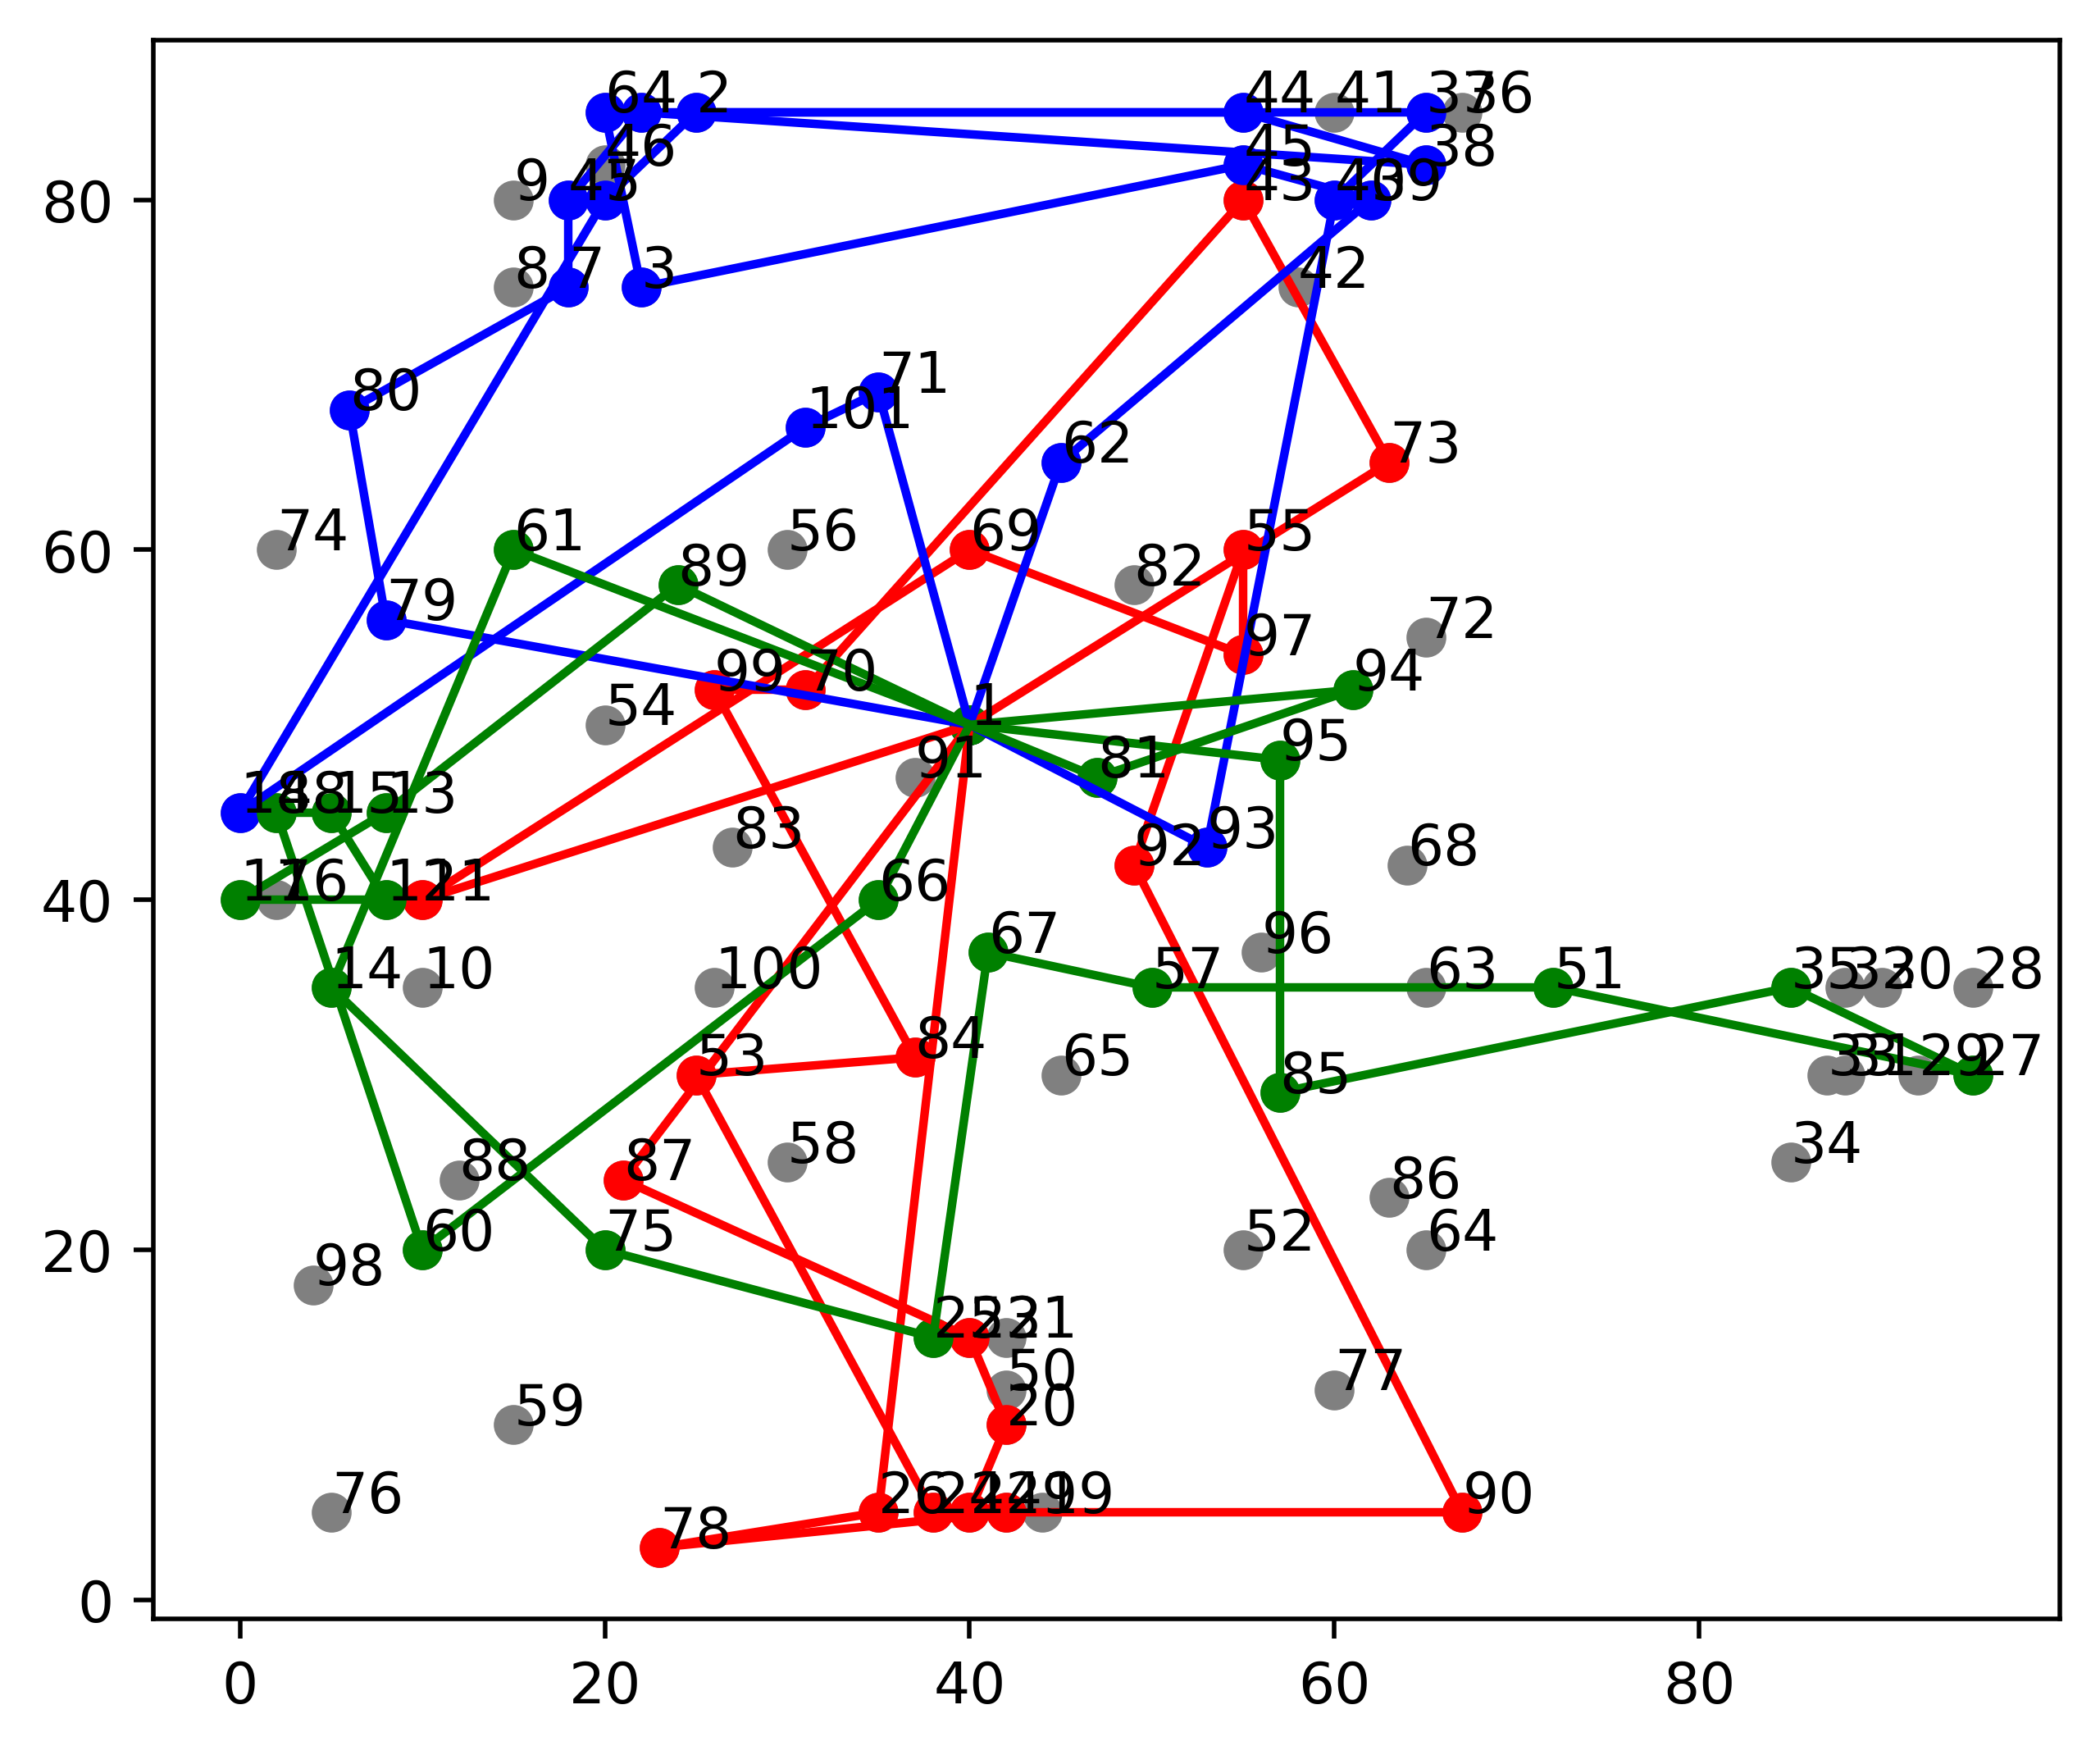

In [ ]:
# Choosing colors
colors = ["red","blue","green",'orange','purple','yellow','black','black']

fig, ax = plt.subplots(figsize=[6, 5], dpi=500)
# ax.set_aspect('equal')

# Now the figure
for i, coord in enumerate(coordinates):
    x = coord[0]
    y= coord[1]
    ax.scatter(x,y, color = 'grey')
    ax.annotate(cust_no[i], (x,y))

#print ('Number of nodes:',N)
for k in range(N_VEHICLES):
    c = colors[k]
    for r in model.R:
        for i in range(len(demands)):
            for j in range(len(demands)):
                if i ==j: 
                    continue
                elif np.isclose(model.X[i, j, k,r].value, 1, atol=1e-1):
                    coord1 = coordinates[i]
                    coord2 = coordinates[j]
                    x1 = coord1[0]
                    y1 = coord1[1]
                    x2 = coord2[0]
                    y2 = coord2[1]
                    if i ==0 :
                        f = 0
                        d = 0
                    else: 
                        demand_shuffled = demands_shuffled[i]
                        f= np.nonzero(demand_shuffled)
                        d = demand_shuffled[f].astype(int)[0]
                        f = f[0][0]

                    ax.scatter(x1,y1, color = c)

                    # ax.annotate((i,d), (x1,y1))
                    ax.plot((x1,x2), (y1,y2), color=c, label= k+1)
#ax.legend()

for k in range(N_VEHICLES):
    print("\nVehicle no:", k+1)
    node = 0
    #print (node, end ='')
    for r in model.R:
        for i in range(len(demands)):
            for j in range(len(demands)):
                    if node == j:
                        continue
                    elif np.isclose(model.X[node, j, k,r].value, 1, atol=1e-1):
                        print (cust_no[node], " --", cust_no[j], end =' ')
                        print ("R:",r)
                        node = j
                        break
            if node == 0:
                break
    #print ("\n")

## Checking loading constraints

In [ ]:
for k in range(N_VEHICLES):
    print('\n',"Vehicle no:", k+1)
    print("Max Capacity of vehicle:", vehicle_capacities[k])
    node = 0
    #print (node, end ='')
    for r in model.R:
        print ('\n', 'Trip:', r)
        #for f in model.F:
        print ('Total loaded onto vehicle', r,':',model.S[k,r].value)
        load = [model.L[0,k,r,f].value for f in model.F]
        print ('Vehicle Load at depot', [model.L[0,k,r,f].value for f in model.F])
        total = np.zeros(DEMAND_TYPES)
        for i in range(len(demands)):
            for j in range(len(demands)):
                    if node == j:
                        continue
                    elif np.isclose(model.X[node, j, k,r].value, 1, atol=1e-1):
                        
                        print ('Cust is:', cust_no[node])
                    
                        print ('Vehicle load', load)
                        print ('Load at node:', demands_shuffled[node])
                        load -= demands_shuffled[node]
                        total += demands_shuffled[node]
                        node = j
                        break
            if node ==0:
                 break
        print ('Remaining Vehicle load', [model.L[N+1,k,r,f].value for f in model.F])
        print('Total delviered:',total)
    '''
    print ('Load at node:', nodes[j])
    print ('Load after visiting node',node,':',model.L[j,k].value)
    print ('\n')
    '''


 Vehicle no: 1
Max Capacity of vehicle: [50 50 50 50 50]

 Trip: 0
Total loaded onto vehicle 0 : 0.0
Vehicle Load at depot [50.0, 50.0, 50.0, 50.0, 50.0]
Remaining Vehicle load [50.0, 50.0, 50.0, 50.0, 50.0]
Total delviered: [0. 0. 0. 0. 0.]

 Trip: 1
Total loaded onto vehicle 1 : 0.0
Vehicle Load at depot [50.0, 50.0, 50.0, 50.0, 50.0]
Remaining Vehicle load [50.0, 50.0, 50.0, 50.0, 50.0]
Total delviered: [0. 0. 0. 0. 0.]

 Trip: 2
Total loaded onto vehicle 2 : 0.0
Vehicle Load at depot [50.0, 50.0, 50.0, 50.0, 50.0]
Remaining Vehicle load [50.0, 50.0, 50.0, 50.0, 50.0]
Total delviered: [0. 0. 0. 0. 0.]

 Trip: 3
Total loaded onto vehicle 3 : 0.0
Vehicle Load at depot [50.0, 50.0, 50.0, 50.0, 50.0]
Cust is: 1
Vehicle load [50.0, 50.0, 50.0, 50.0, 50.0]
Load at node: [0 0 0 0 0]
Cust is: 73
Vehicle load [50. 50. 50. 50. 50.]
Load at node: [8 0 0 0 0]
Cust is: 43
Vehicle load [42. 50. 50. 50. 50.]
Load at node: [ 0 10  0  0  0]
Cust is: 70
Vehicle load [42. 40. 50. 50. 50.]
Load at nod

## Checking time constraints

In [ ]:
for k in range(N_VEHICLES):
    print("Vehicle no:", k+1)
    node = 0
    #print (node, end ='')
    for r in model.R:
        print ('\n', 'Trip no:', r)
        print ('Total load of trip', r,':',model.S[k,r].value)
        for i in range(len(demands)):
            for j in range(len(demands)):
                    if node == j:
                        continue
                    elif np.isclose(model.X[node, j, k,r].value, 1, atol=1e-1):
                        print ('Time window at cust:',cust_no[node],': [', model.a[node], model.b[node], ']')
                        print ('Time reach cust:',cust_no[node],':', model.T[node,k,r].value, '\n')
                        print ('Service time:', model.s[node])
                        print ('Travel time from', cust_no[node],'to', cust_no[j] ,':', model.t[node,j], '\n')
                        node = j
                        break
            if node ==0:
                 break
        print ('Time at end,',r,':', model.T[N+1,k,r].value)
        #print ('Total load of trip', r,':',model.S[k,r].value)
        #print ('Start time at next trip,',r+1,':', model.T[0,k,r+1].value)

Vehicle no: 1

 Trip no: 0
Total load of trip 0 : 0.0
Time at end, 0 : 0.0

 Trip no: 1
Total load of trip 1 : 0.0
Time at end, 1 : 0.0

 Trip no: 2
Total load of trip 2 : 0.0
Time at end, 2 : 7.8

 Trip no: 3
Total load of trip 3 : 0.0
Time window at cust: 1 : [ 0 960 ]
Time reach cust: 1 : 7.8 

Service time: 0
Travel time from 1 to 73 : 27.4 

Time window at cust: 73 : [ 60 180 ]
Time reach cust: 73 : 85.2 

Service time: 8
Travel time from 73 to 43 : 17.0 

Time window at cust: 43 : [ 33 153 ]
Time reach cust: 43 : 110.2 

Service time: 10
Travel time from 43 to 70 : 36.8 

Time window at cust: 70 : [ 157 277 ]
Time reach cust: 70 : 160.3 

Service time: 27
Travel time from 70 to 99 : 5.0 

Time window at cust: 99 : [ 172 292 ]
Time reach cust: 99 : 192.3 

Service time: 9
Travel time from 99 to 84 : 23.7 

Time window at cust: 84 : [ 105 225 ]
Time reach cust: 84 : 225.0 

Service time: 14
Travel time from 84 to 53 : 12.0 

Time window at cust: 53 : [ 175 295 ]
Time reach cust: 53

## Schedules per vessel

"\nfor n in range(len(demands)):\n    if sum(model.Y[n,k,r].value for k in range(N_VEHICLES) for r in range(R)) != 1:\n        start_time_at_node = model.a[n]\n        service_time_at_node = model.b[n] - model.a[n]\n        ax.add_patch(plt.Rectangle((4-0.25, start_time_at_node), 0.5, service_time_at_node, edgecolor='green',                                            linewidth=2,facecolor='none'))\n        ax.text(4-0.125, start_time_at_node, n, color = 'black', fontsize = 8)\n        "

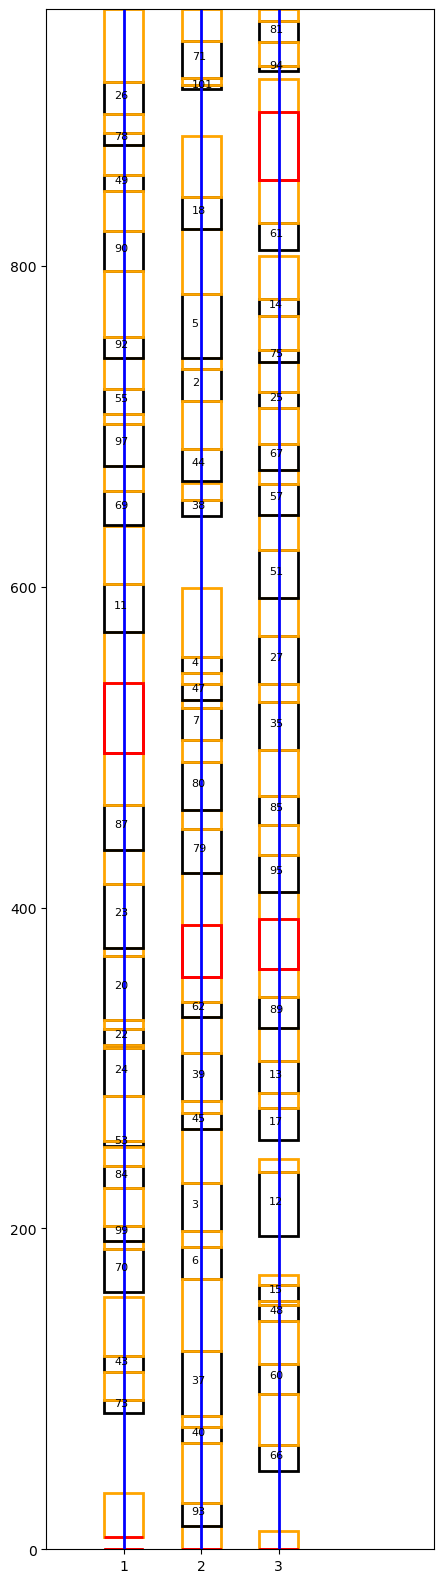

In [ ]:
fig, ax = plt.subplots(figsize = (5,20))
ax.set_xlim(0, N_VEHICLES + 2)
ax.set_ylim(START_TIME, END_TIME)
ax.set_xticks(np.arange(1, N_VEHICLES + 1))
#ax.set_yticks([i for i in range(0,int(yaxislength)+1,43200)])
for k in range(N_VEHICLES):
    ax.plot([k+1, k+1], [START_TIME,END_TIME], linewidth=2, color='b')  #vessel docking period
    for r in range(R): #range(R):
        for i in range(len(demands)):
            for j in range(len(demands)):
                if i ==j: 
                    continue
                elif np.isclose(model.X[i, j, k,r].value, 1, atol=1e-1):
                    
                    time_start_at_node = model.T[i,k,r].value
                    if i !=0: #servicing customers
                        service_time_at_node = model.s[i]
                        ax.add_patch(plt.Rectangle((k+1-0.25, time_start_at_node), 0.5, service_time_at_node, edgecolor='black',\
                                        linewidth=2,facecolor='none'))
                        ax.text(k+1-0.125, time_start_at_node+(service_time_at_node/2), cust_no[i], color = 'black', fontsize = 8)
                    else: #starting at terminal
                        service_time_at_node = model.S[k,r].value
                        ax.add_patch(plt.Rectangle((k+1-0.25, time_start_at_node), 0.5, service_time_at_node, edgecolor='red',\
                                        linewidth=2,facecolor='none'))
                    travelling_time = model.t[i,j]
                    ax.add_patch(plt.Rectangle((k+1-0.25, time_start_at_node+service_time_at_node), 0.5, travelling_time, edgecolor='orange',\
                                        linewidth=2,facecolor='none'))

for k in range(N_VEHICLES):
    for r in range(R):
        time_start_at_node = model.T[0,k,r].value
        service_time_at_node = model.S[k,r].value
        ax.add_patch(plt.Rectangle((k+1-0.25, time_start_at_node), 0.5, service_time_at_node, edgecolor='red',\
                        linewidth=2,facecolor='none'))
                        
'''
for n in range(len(demands)):
    if sum(model.Y[n,k,r].value for k in range(N_VEHICLES) for r in range(R)) != 1:
        start_time_at_node = model.a[n]
        service_time_at_node = model.b[n] - model.a[n]
        ax.add_patch(plt.Rectangle((4-0.25, start_time_at_node), 0.5, service_time_at_node, edgecolor='green',\
                                            linewidth=2,facecolor='none'))
        ax.text(4-0.125, start_time_at_node, n, color = 'black', fontsize = 8)
        '''

## Solution Pool

In [ ]:
SOLUTION_POOL = False
if SOVLER_ENGINE == 'gurobi_persistent':
    SOLUTION_POOL = True
else:
    SOLUTION_POOL = False

In [ ]:
if SOLUTION_POOL:
    # Print number of solutions stored
    nSolutions = solver.get_model_attr("SolCount")
    print('Number of solutions found: ' + str(nSolutions))

    # Print objective values of solutions
    for e in range(nSolutions):
        solver.set_gurobi_param("SolutionNumber", e)
        print('%g ' % solver.get_model_attr("PoolObjVal"), end='')
    print('')

In [ ]:
if SOLUTION_POOL:
    # Print variable values of different solutions
    solver.set_gurobi_param("SolutionNumber", 0)
    values = solver.get_model_attr('Xn')
    names = solver.get_model_attr('VarName')
    obj = solver.get_model_attr('PoolObjVal')
    print(obj)

In [ ]:
def variable_spliting(model,values):
    #this is iffy
    L_end = len(model.N1) * len(model.K) * len(model.R) * len(model.F)
    L_initial_end =  L_end + len(model.K) * len(model.F)
    S_end = L_initial_end + len(model.K) * len(model.R)
    T_end = S_end + len(model.N1) * len(model.K) * len(model.R)
    X_end = T_end + len(model.A) * len(model.K) * len(model.R)
    Y_end = X_end + len(model.N) * len(model.K) * len(model.R)

    L_variable = values[0:L_end]
    L_inital_variable = values[L_end:L_initial_end]
    S_variable = values[L_initial_end:S_end]
    T_variable = values[S_end:T_end]
    X_variable = values[T_end:X_end]
    Y_variable = values[X_end:Y_end]
    Z_variable = values[Y_end:]

    return L_variable, L_inital_variable,S_variable,T_variable,X_variable,Y_variable,Z_variable

L_variable, L_inital_variable,S_variable,T_variable,X_variable,Y_variable,Z_variable = variable_spliting(model,values)

NameError: name 'values' is not defined

In [ ]:
def variable_dictionary(model,L_variable, L_inital_variable,S_variable,T_variable,X_variable,Y_variable,Z_variable):
    S_dict = {}
    count_s = 0
    for k in model.K:
        for r in model.R:
                S_dict[k,r] = S_variable[count_s]
                count_s +=1
    T_dict = {}
    count_t = 0
    for i in model.N1:
        for k in model.K:
            for r in model.R:
                T_dict[i,k,r] = T_variable[count_t]
                count_t +=1

    X_dict = {}
    count_x = 0
    for i,j in model.A:
        for k in model.K:
            for r in model.R:
                X_dict[i,j,k,r] = X_variable[count_x]
                count_x +=1

    Y_dict = {}
    count_y = 0
    for i in model.N:
        for k in model.K:
            for r in model.R:
                Y_dict[i,k,r] = Y_variable[count_y]
                count_y +=1

    Z_dict = {}
    count_z = 0
    for k in model.K:
        for r in model.R:
            for f in model.F:
                Z_dict[k,r,f] = Z_variable[count_z]
                count_z +=1
    
    return S_dict,T_dict,X_dict,Y_dict,Z_dict

S_dict,T_dict,X_dict,Y_dict,Z_dict = variable_dictionary(model,L_variable, L_inital_variable,S_variable,T_variable,X_variable,Y_variable,Z_variable)

In [ ]:
if SOLUTION_POOL:
    print ('Total amount of goods delivered:',sum(
        X_dict[i, j, k,r] * np.abs(model.n[i,f])
        for (i, j) in model.A
        for k in model.K
        for r in model.R
        for f in model.F
        ) )

    print ('Total number of vessels visited:', sum(Y_dict[i,k,r]
                                                for i in model.D
                                                for k in model.K
                                                for r in model.R))

    print ('Total travel time:', sum( X_dict[i, j, k,r] * model.t[i,j]
                                                for (i,j) in model.A
                                                for k in model.K
                                                for r in model.R))

In [ ]:
if SOLUTION_POOL:
    # Choosing colors
    cmap = mpl.colormaps["Dark2"]
    #colors = cycle(cmap.colors)
    colors = ["red","blue","green",'orange','purple','yellow','black','black']


    # Now the figure
    fig, ax = plt.subplots(figsize=[6, 5], dpi=300)

    for i, coord in enumerate(coordinates):
        x = coord[0]
        y= coord[1]
        ax.scatter(x,y, color = 'grey')
        ax.annotate(cust_no[i], (x,y))
    #print ('Number of nodes:',N)
    for k in range(N_VEHICLES):
        c = colors[k]
        for r in model.R:
            for i in range(len(demands)):
                for j in range(len(demands)):
                    if i ==j: 
                        continue
                    elif np.isclose(X_dict[i, j, k,r], 1, atol=1e-1):
                        coord1 = coordinates[i]
                        coord2 = coordinates[j]
                        x1 = coord1[0]
                        y1 = coord1[1]
                        x2 = coord2[0]
                        y2 = coord2[1]
                        if i ==0 :
                            f = 0
                            d = 0
                        else: 
                            demand_shuffled = demands_shuffled[i]
                            f= np.nonzero(demand_shuffled)
                            d = demand_shuffled[f].astype(int)[0]
                            f = f[0][0]

                        ax.scatter(x1,y1, color = c)

                        # ax.annotate((i,d), (x1,y1))
                        ax.plot((x1,x2), (y1,y2), color=c, label= k+1)
    #ax.legend()

    for k in range(N_VEHICLES):
        print("\nVehicle no:", k+1)
        node = 0
        #print (node, end ='')
        for r in model.R:
            for i in range(len(demands)):
                for j in range(len(demands)):
                        if node == j:
                            continue
                        elif np.isclose(X_dict[node, j, k,r], 1, atol=1e-1):
                            print (cust_no[node], " --", cust_no[j], end =' ')
                            print ("R:",r)
                            node = j
                            break
                if node == 0:
                    break
        #print ("\n")
    plt.show()

In [ ]:
if SOLUTION_POOL:
    FILE_PATH = 'images/'
    IMAGE_NAME = 'test'
    for sol_index in range(nSolutions-1,-1,-1):
        solver.set_gurobi_param("SolutionNumber", sol_index)
        values = solver.get_model_attr('Xn')
        names = solver.get_model_attr('VarName')
        obj = solver.get_model_attr('PoolObjVal')
        
        L_variable, L_inital_variable,S_variable,T_variable,X_variable,Y_variable,Z_variable = variable_spliting(model,values)

        S_dict,T_dict,X_dict,Y_dict,Z_dict = variable_dictionary(model,L_variable, L_inital_variable,S_variable,T_variable, X_variable,Y_variable,Z_variable)
        
        colors = ["red","blue","green",'orange','purple','yellow','black','black']

        total_goods = sum(
            X_dict[i, j, k,r] * np.abs(model.n[i,f])
            for (i, j) in model.A
            for k in model.K
            for r in model.R
            for f in model.F
            )
        vessels_visited = sum(Y_dict[i,k,r] for i in model.D for k in model.K for r in model.R) 

        total_travel_time = sum( X_dict[i, j, k,r] * model.t[i,j]
                                                for (i,j) in model.A
                                                for k in model.K
                                                for r in model.R)
        comments = 'obj:'+str(np.round(obj,3)) + '\n' \
        'total goods delivered:' +str(total_goods) + '\n'\
        'Number of vessels visited:' + str(vessels_visited) + '\n'\
        'Total travel time: ' + str(np.round(total_travel_time,2))
        # Now the figure
        fig, ax = plt.subplots(figsize=[6, 5], dpi=250)

        for i, coord in enumerate(coordinates):
            x = coord[0]
            y= coord[1]
            ax.scatter(x,y, color = 'grey')
            ax.annotate(cust_no[i], (x,y))
        #print ('Number of nodes:',N)
        for k in range(N_VEHICLES):
            c = colors[k]
            for r in model.R:
                for i in range(len(demands)):
                    for j in range(len(demands)):
                        if i ==j: 
                            continue
                        elif np.isclose(X_dict[i, j, k,r], 1, atol=1e-1):
                            coord1 = coordinates[i]
                            coord2 = coordinates[j]
                            x1 = coord1[0]
                            y1 = coord1[1]
                            x2 = coord2[0]
                            y2 = coord2[1]
                            if i ==0 :
                                f = 0
                                d = 0
                            else: 
                                demand_shuffled = demands_shuffled[i]
                                f= np.nonzero(demand_shuffled)
                                d = demand_shuffled[f].astype(int)[0]
                                f = f[0][0]

                            ax.scatter(x1,y1, color = c)

                            # ax.annotate((i,d), (x1,y1))
                            ax.plot((x1,x2), (y1,y2), color=c, label= k+1)
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 1.25, comments, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
        plt.tight_layout()
        # fig.savefig(FILE_PATH+IMAGE_NAME+str(sol_index)+'.png', dpi = fig.dpi)